In [1]:
# Imports 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from keras import backend as K
import matplotlib.pyplot as plt 

In [2]:
# Import data
data = pd.read_csv("../../../data/mturk_experiment_2.csv",encoding='unicode_escape')
labels = data["Formality"]
samples = data["Sentence"]

train_samples, test_samples, train_labels,test_labels = train_test_split(samples, labels, test_size=0.2,random_state=5)

train_samples = np.array(train_samples)
test_samples = np.array(test_samples)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [24]:
# Model setup

# Attention layer
class peel_the_layer(tf.keras.layers.Layer): 

    def __init__(self):    
        ##Nothing special to be done here
        super(peel_the_layer, self).__init__()

    def build(self, input_shape):
        ##Define the shape of the weights and bias in this layer
        ##This is a 1 unit layer. 
        units=1
        ##last index of the input_shape is the number of dimensions of the prev
        ##RNN layer. last but 1 index is the num of timesteps
        self.w=self.add_weight(name="att_weights", shape=(input_shape[-1], units), initializer="normal") #name property is useful for avoiding RuntimeError: Unable to create link.
        self.b=self.add_weight(name="att_bias", shape=(input_shape[-2], units), initializer="zeros")
        super(peel_the_layer,self).build(input_shape)

    def call(self, x):
        ##x is the input tensor..each word that needs to be attended to
        ##Below is the main processing done during training
        ##K is the Keras Backend import
        e = K.tanh(K.dot(x,self.w)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a

        ##return the ouputs. 'a' is the set of attention weights
        ##the second variable is the 'attention adjusted o/p state' or context
        return a, K.sum(output, axis=1)

    def get_config(self):
            return 

    @classmethod
    def from_config(cls, config):
        return cls(**config)

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/2'
tfhub_handle_preprocess =   'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
net = outputs['pooled_output']
reshaped = tf.reshape(net,[-1, 1024, 1])
lstm = tf.keras.layers.LSTM(512,return_sequences=True)(reshaped)
a, context = peel_the_layer()(lstm)

dense = tf.keras.layers.Dense(1)(context)
model = tf.keras.Model(text_input, dense)
model.summary()

loss = 'mse'
metrics = [tf.keras.metrics.MeanSquaredError(),tf.keras.losses.MeanAbsoluteError(),tf.keras.losses.MeanAbsolutePercentageError()]
optimiser = tf.optimizers.Adam(learning_rate= 5e-5)

model.compile(optimizer=optimiser, loss=loss, metrics=metrics)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'encoder_outputs':  435915777   preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

Epoch 1/20
176/176 - 15434s - loss: 3.7873 - mean_squared_error: 3.7873 - mean_absolute_error: 1.4092 - mean_absolute_percentage_error: 37.7172
Epoch 2/20
176/176 - 15536s - loss: 0.5323 - mean_squared_error: 0.5323 - mean_absolute_error: 0.5815 - mean_absolute_percentage_error: 16.4583
Epoch 3/20
176/176 - 15722s - loss: 0.3409 - mean_squared_error: 0.3409 - mean_absolute_error: 0.4598 - mean_absolute_percentage_error: 12.5897
Epoch 4/20
176/176 - 16105s - loss: 0.2086 - mean_squared_error: 0.2086 - mean_absolute_error: 0.3485 - mean_absolute_percentage_error: 9.2518
Epoch 5/20
176/176 - 15904s - loss: 0.1550 - mean_squared_error: 0.1550 - mean_absolute_error: 0.2963 - mean_absolute_percentage_error: 7.7768
Epoch 6/20
176/176 - 15964s - loss: 0.1002 - mean_squared_error: 0.1002 - mean_absolute_error: 0.2381 - mean_absolute_percentage_error: 6.3454
Epoch 7/20
176/176 - 15883s - loss: 0.4184 - mean_squared_error: 0.4184 - mean_absolute_error: 0.4925 - mean_absolute_percentage_error: 13.

,BERT Large - Epochs - 20 Batch Size - 32
0,1.157408
1,1.157408
2,0.902806
3,25.429272


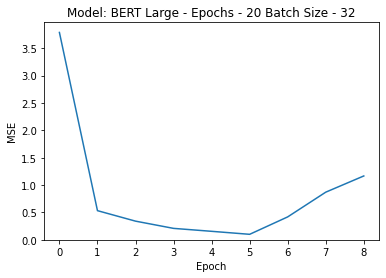

In [4]:
epochs = 20
batch_size = 32
results = pd.DataFrame()

# CHANGE EARLY STOPPING 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3,min_delta=0.01)
history = model.fit(x=train_samples,y=train_labels,batch_size=batch_size,epochs=epochs,verbose=2,callbacks=[callback])

scores = model.evaluate(x=test_samples,y=test_labels)
model_label = "BERT Large - Epochs - " + str(epochs) + " Batch Size - " + str(batch_size)

results[model_label] = scores

mse = history.history['mean_squared_error']

plt.plot(mse)
plt.title("Model: " + model_label)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.ylim(bottom=0)
plt.savefig(model_label + ".jpeg",dpi=100,bbox_inches='tight')

results

In [5]:
# IF THIS MODEL IS ANY GOOD, REMEMBER TO SAVE IT!

In [23]:
#model.save('bertissimo')
model.save('bertissimo.h5')

AttributeError: 'peel_the_layer' object has no attribute 'hidden_units'

In [20]:
loaded_1 = tf.keras.models.load_model(
    "bertissimo.h5", custom_objects={"peel_the_layer": peel_the_layer}
)

ValueError: Unknown layer: KerasLayer. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.